# Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

In [2]:
EMP=pd.read_csv("https://raw.githubusercontent.com/kilianguillon/Projet_statapp/main/data/EMP_deplacements_Charme.csv",
                sep=";", encoding='latin-1')

In [3]:
#Création d'une base ne prenant que les premiers trajets
EMP_prems = EMP[EMP["num_dep_V"]==1]

# Lieu du premier déplacement de la journée

In [4]:
pd.DataFrame(EMP_prems["Motif"].value_counts()).head() #Motif du déplacement (pas de pondération)

,count
Motif,
Travailler dans son lieu fixe et habituel,1838
Se rendre dans une grande surface ou un centre commercial (y compris boutiques et services),1111
"Se rendre dans un centre de proximité, petit commerce, supérette, boutiques, services (banque, cordonnier.) (hors centre commercial)",891
Visite à la famille,471
Accompagner quelqu'un à un autre endroit,408


In [5]:
#Arrivée du déplacement pas de pond
pd.DataFrame(EMP_prems["Lieu_Arrivee"].value_counts())

,count
Lieu_Arrivee,
Rue,2577
Parking,2486
Entreprise,1441
Domicile,570
Sans,275


Pour pouvoir correctement évaluer les habitudes de déplacement, on doit pondérer chaque voyage. Etant donné que c'est un besoin récurrent, je crée une fonction qui prend en entrée un DF et la variable dont l'on veut connaître les occurences de ses entrées. La fonction rend une table avec les occurences pondérées et la proportion.

In [6]:
def count_occ_pond(data, nom_var, nom_pond, taille=10):
    value = data[nom_var].unique() #cette fonction est utile pour des variables prenant un nbre de valeurs finies
    result_dict = {nom_var: [], 'Occurences pondérées': [], 'Proportion':[]} #à chaque valeur on associe la somme des occurences pondérées
    N=data[nom_pond].replace(',', '.', regex=True).astype(float).sum()
    for val in value :
        somme_pond = data[data[nom_var] == val][nom_pond].replace(',', '.', regex=True).astype(float).sum() #replace car la base utilisée est "française"
        result_dict[nom_var].append(val)
        result_dict['Occurences pondérées'].append(somme_pond)
        result_dict['Proportion'].append(round(100*somme_pond/N,2))
    return pd.DataFrame(result_dict).sort_values('Occurences pondérées', ascending=False).reset_index(drop=True).head(taille)

In [7]:
count_occ_pond(EMP_prems, "Motif", "POND_JOUR")

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.820732e+07,27.04
1,Se rendre dans une grande surface ou un centre...,2.253802e+07,12.64
2,"Se rendre dans un centre de proximité, petit c...",1.891414e+07,10.61
3,Accompagner quelqu'un à un autre endroit,1.351374e+07,7.58
4,Visite à la famille,1.072364e+07,6.02
5,"Soins médicaux ou personnels (médecin, coiffeur.)",6.666349e+06,3.74
6,Visite à des amis,6.128020e+06,3.44
7,Faire du sport,5.893799e+06,3.31
8,Aller chercher quelqu'un à un autre endroit,5.076578e+06,2.85
9,Travailler en dehors d'un lieu fixe et habitue...,4.679032e+06,2.62


In [8]:
count_occ_pond(EMP_prems, "Lieu_Arrivee", "POND_JOUR")

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,6.142194e+07,34.45
1,Parking,5.700055e+07,31.97
2,Entreprise,3.775752e+07,21.18
3,Domicile,1.366802e+07,7.67
4,Sans,8.432261e+06,4.73


# Lieu en fonction de l'heure d'arrivée et du jour

## Week_end ou non ?

In [9]:
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP_prems.loc[:, "WE"] = 0
EMP_prems.loc[EMP_prems["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1

/tmp/ipykernel_358/3819941130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems.loc[:, "WE"] = 0


On regroupe samedi et dimanche pour simplifier. Les habitudes de premier déplacement sont légèrement différentes (plus de visite à la famille ou retour au domicile le dimanche), mais ces deux jours différent encore plus avec les autres.

#count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="samedi"], "Motif", "POND_JOUR"), count_occ_pond(EMP_prems[EMP_prems["TYPE_jour"]=="dimanche"], "Motif", "POND_JOUR")

In [10]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Motif", "POND_JOUR") #Motif de premier déplacement en semaine

,Motif,Occurences pondérées,Proportion
0,Travailler dans son lieu fixe et habituel,4.473707e+07,33.36
1,Se rendre dans une grande surface ou un centre...,1.471521e+07,10.97
2,Accompagner quelqu'un à un autre endroit,1.151086e+07,8.58
3,"Se rendre dans un centre de proximité, petit c...",1.102945e+07,8.23
4,"Soins médicaux ou personnels (médecin, coiffeur.)",6.023393e+06,4.49
5,Visite à la famille,5.599544e+06,4.18
6,Travailler en dehors d'un lieu fixe et habitue...,4.283752e+06,3.19
7,Aller chercher quelqu'un à un autre endroit,4.032286e+06,3.01
8,Visite à des amis,3.655889e+06,2.73
9,Faire du sport,3.294035e+06,2.46


In [11]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Lieu_Arrivee", "POND_JOUR") #Lieu arrivée premier déplacement en semaine

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Rue,4.455184e+07,33.22
1,Parking,3.935525e+07,29.35
2,Entreprise,3.467059e+07,25.85
3,Domicile,8.618989e+06,6.43
4,Sans,6.899742e+06,5.15


In [12]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Motif", "POND_JOUR") #Motif de premier déplacement en WE

,Motif,Occurences pondérées,Proportion
0,"Se rendre dans un centre de proximité, petit c...",7.884686e+06,17.85
1,Se rendre dans une grande surface ou un centre...,7.822811e+06,17.71
2,Visite à la famille,5.124099e+06,11.60
3,Travailler dans son lieu fixe et habituel,3.470241e+06,7.85
4,Faire du sport,2.599764e+06,5.88
5,Visite à des amis,2.472131e+06,5.60
6,"Activité associative, cérémonie religieuse, ré...",2.151604e+06,4.87
7,Accompagner quelqu'un à un autre endroit,2.002878e+06,4.53
8,Se rendre sur un lieu de promenade,1.963082e+06,4.44
9,Manger ou boire à l'extérieur du domicile,1.185048e+06,2.68


In [13]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Lieu_Arrivee", "POND_JOUR") #le WE

,Lieu_Arrivee,Occurences pondérées,Proportion
0,Parking,1.764530e+07,39.94
1,Rue,1.687010e+07,38.18
2,Domicile,5.049031e+06,11.43
3,Entreprise,3.086933e+06,6.99
4,Sans,1.532519e+06,3.47


## Premier lieu par heure

In [14]:
for h in range(0,24):
    EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR") #heure d'arrivée du premier trajet en semaine

/tmp/ipykernel_358/3391152489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)


,H_ARR,Occurences pondérées,Proportion
0,8.0,2.976929e+07,22.20
1,7.0,2.213325e+07,16.51
2,9.0,1.832836e+07,13.67
3,10.0,1.298932e+07,9.69
4,11.0,7.437903e+06,5.55
5,14.0,7.204150e+06,5.37
6,6.0,5.256828e+06,3.92
7,15.0,4.539262e+06,3.39
8,13.0,4.047905e+06,3.02
9,12.0,3.677261e+06,2.74


In [15]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24) #heure d'arrivée du premier trajet en WE

,H_ARR,Occurences pondérées,Proportion
0,10.0,8.597888e+06,19.46
1,9.0,5.796881e+06,13.12
2,11.0,5.751904e+06,13.02
3,8.0,3.457154e+06,7.82
4,14.0,3.374319e+06,7.64
5,15.0,3.269877e+06,7.40
6,16.0,2.563478e+06,5.80
7,12.0,2.548125e+06,5.77
8,13.0,1.920453e+06,4.35
9,7.0,1.414345e+06,3.20


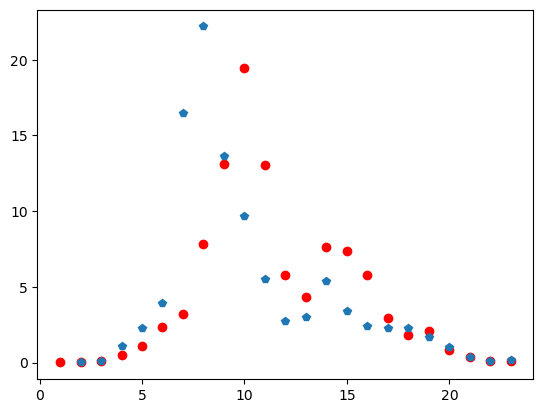

In [16]:
plt.plot(count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "H_ARR", "POND_JOUR",24)["Proportion"],'ro')
plt.plot(count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "H_ARR", "POND_JOUR",24)["Proportion"],'p')
plt.show()

In [17]:
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_prems[EMP_prems["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)


In [18]:
#On crée une fonction retirant les heures n'ayant pas assez d'occurences (étant donné qu'on affiche dans le graphique des proportions)
def limiter(df, nom_var, precision=1000):
    
    limiter=df[nom_var].sum()/precision #si une heure a moins de limiter occurences pond, alors on l'omet
    
    H_occ_pond=pd.DataFrame(df.groupby("Heure")[nom_var].sum())
    H_occ_pond = H_occ_pond.rename(columns={nom_var: "Occ_H"}) #on rajoute Occ_H, le nombre d'occurences pond par h
   
    results = pd.merge(df, H_occ_pond, on='Heure', how='left')
    results = results[results["Occ_H"] >= limiter]
    return results

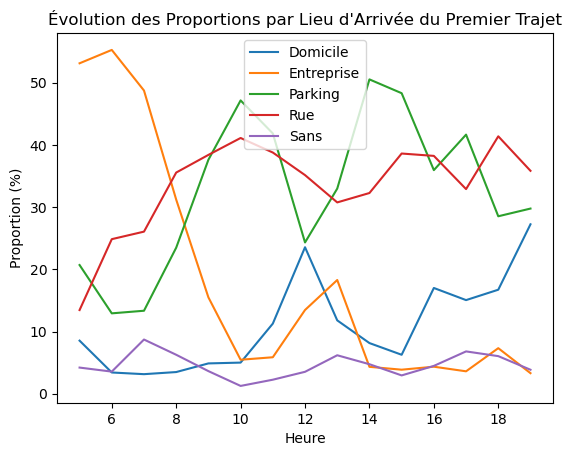

In [19]:
results=limiter(results, "Occurences pondérées",100)

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des Proportions par Lieu d'Arrivée du Premier Trajet")
ax.legend()
plt.show()

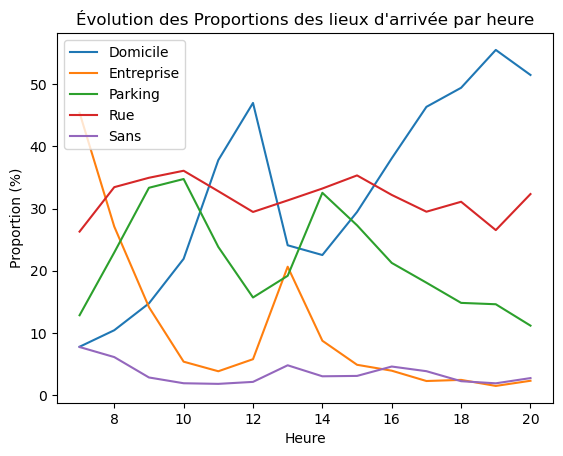

In [76]:
for h in range(0,24):
    EMP.loc[(EMP["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

count_occ_pond(EMP, "H_ARR", "POND_JOUR") #heure d'arrivée du premier trajet en semaine
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP[EMP["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)
#On crée une fonction retirant les heures n'ayant pas assez d'occurences (étant donné qu'on affiche dans le graphique des proportions)
def limiter(df, nom_var, precision=1000):
    
    limiter=df[nom_var].sum()/precision #si une heure a moins de limiter occurences pond, alors on l'omet
    
    H_occ_pond=pd.DataFrame(df.groupby("Heure")[nom_var].sum())
    H_occ_pond = H_occ_pond.rename(columns={nom_var: "Occ_H"}) #on rajoute Occ_H, le nombre d'occurences pond par h
   
    results = pd.merge(df, H_occ_pond, on='Heure', how='left')
    results = results[results["Occ_H"] >= limiter]
    return results

results=limiter(results, "Occurences pondérées",50)

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des Proportions des lieux d'arrivée par heure")
ax.legend()
plt.show()


In [65]:
import pandas as pd
from scipy.stats import chi2_contingency

# Supposons que votre DataFrame s'appelle 'emp_data'

# Créer une table de contingence entre les variables Lieu_Arrivée et Lieu_Départ
contingency_table = pd.crosstab(EMP['Lieu_Arrivee'], EMP['Lieu_Depart'])

# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)

# Effectuer le test du chi carré d'indépendance
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("\nRésultats du test du Chi carré :")
print(f"- Statistique du test du Chi carré : {chi2:.2f}")
print(f"- p-value : {p_value:.4f}")
print(f"- Degrés de liberté : {dof}")


Table de contingence :
Lieu_Depart   Domicile  Entreprise  Parking   Rue  Sans
Lieu_Arrivee                                           
Domicile          1145        1153     2674  2520   289
Entreprise        1343         117      151   512    45
Parking           2468         277      907  1179   114
Rue               2555         562     1080  2672   134
Sans               321          39       81   146    42

Résultats du test du Chi carré :
- Statistique du test du Chi carré : 3414.55
- p-value : 0.0000
- Degrés de liberté : 16


# Lieu de la dernière arrivée

In [20]:
EMP_last = pd.merge(EMP, EMP.groupby("IDENT_IND")["num_dep_V"].max().reset_index(), on='IDENT_IND', how='left')
EMP_last = EMP_last[EMP_last["num_dep_V_x"]==EMP_last["num_dep_V_y"]]
EMP_last.head()

,IDENT_IND,IDENT_MEN,MVEH,POND_JOUR,MOTPREC,MMOTIFDES,MSTATION,Motif,Stationnement,Lieu_Depart,...,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,KVAQUIV,TRAVAILLE,Segment_detail,IDENT_V,Segment,num_dep_V_x,num_dep_V_y
1,110000011400001,1100000114000,1,"9891,108772",2.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-03 14:45:00,2029-01-03 14:50:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,2,2
3,110000011500001,1100000115000,2,"5275,2959481",1.4,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,2029-01-05 10:30:00,2029-01-05 11:00:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,2,2
5,110000013500002,1100000135000,1,"24058,724023",9.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Entreprise,...,2029-01-03 23:45:00,2029-01-03 23:55:00,"5,3214103219",1.0,1,Particulier,110000013500002_1_Particulier,Particulier,2,2
7,110000013600001,1100000136000,1,"20658,322154",9.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,2029-01-02 18:00:00,2029-01-02 19:00:00,"25,232498723",1.0,1,Particulier,110000013600001_1_Particulier,Particulier,2,2
9,110000014400001,1100000144000,2,"31828,347792",2.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,2029-01-06 09:15:00,2029-01-06 09:25:00,3,1.0,1,Particulier,110000014400001_2_Particulier,Particulier,2,2


In [21]:
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP_last.loc[:, "WE"] = 0
EMP_last.loc[EMP_last["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1

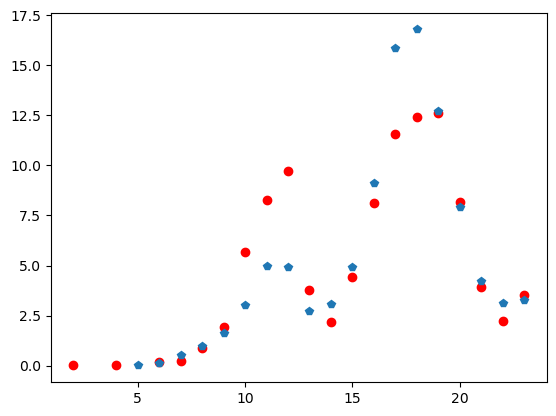

In [22]:
for h in range(0,24):
    EMP_last.loc[(EMP_last["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_last["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

plt.plot(count_occ_pond(EMP_last[EMP_last["WE"]==1], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_last[EMP_last["WE"]==1], "H_ARR", "POND_JOUR",24)["Proportion"],'ro')
plt.plot(count_occ_pond(EMP_last[EMP_last["WE"]==0], "H_ARR", "POND_JOUR",24)["H_ARR"],count_occ_pond(EMP_last[EMP_last["WE"]==0], "H_ARR", "POND_JOUR",24)["Proportion"],'p')
plt.show()

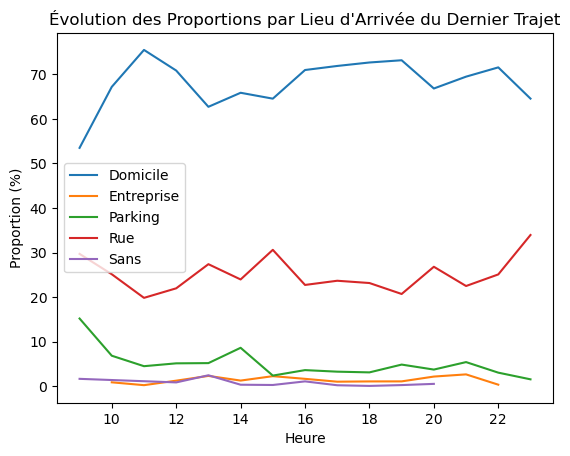

In [23]:
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_last[EMP_last["H_ARR"]==h], "Lieu_Arrivee", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)

results=limiter(results, "Occurences pondérées",100) #on ôte les heures ayant peu de données

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Arrivee"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des Proportions par Lieu d'Arrivée du Dernier Trajet")
ax.legend()
plt.show()

# Les proportions sont-elles statistiquement constantes dans le temps (pour le dernier trajet)?

On commence par effectuer une régression simple de la proportion d'individus se garant pour leur dernier trajet à leur domicile. On utilise le tableau produit ci-dessus.

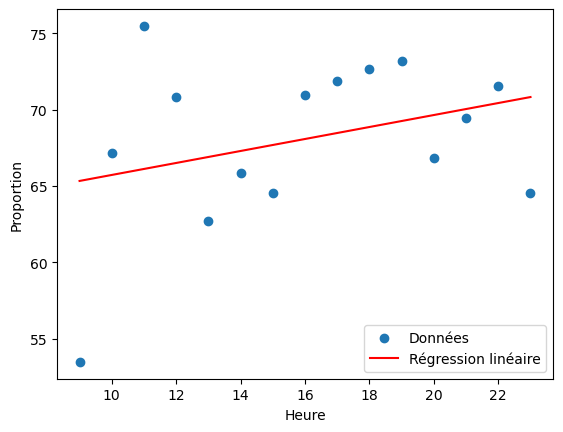

Coefficient de pente (slope): 0.39217857142857127
Terme constant (intercept): 61.80514285714284
Valeur de r (corrélation): 0.3201805224588897
Valeur de p (p-value): 0.24465717734354428


In [24]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

results=results[results["Lieu_Arrivee"]=="Domicile"]

# Extraction des colonnes pertinentes
heure = results["Heure"]
proportion = results["Proportion"]

# Calcul de la régression linéaire
slope, intercept, r_value, p_value, std_err = linregress(heure, proportion)

# Affichage de la régression linéaire
plt.scatter(heure, proportion, label='Données')
plt.plot(heure, intercept + slope * heure, 'r', label='Régression linéaire')
plt.xlabel('Heure')
plt.ylabel('Proportion')
plt.legend()
plt.show()

# Affichage des coefficients de la régression
print(f"Coefficient de pente (slope): {slope}")
print(f"Terme constant (intercept): {intercept}")
print(f"Valeur de r (corrélation): {r_value}")
print(f"Valeur de p (p-value): {p_value}")


La régression est grossière et ne montre rien car on n'a que 24 entrées. On va donc revenir à la base de données brutes (ne prenant en compte que les derniers trajets).
On effectue un test du chi² d'indépendance, l'objectif étant de vérifier que la proportion de personnes pour chaque lieu d'arrivée est indépendante du temps. (à vérifier)

In [25]:
from scipy.stats import chi2_contingency

# Créer une table de contingence pour le test du chi-carré
contingency_table = pd.crosstab(EMP_last['Lieu_Arrivee'], EMP_last['H_ARR'])

# Effectuer le test du chi-carré
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Afficher les résultats du test du chi-carré
print("Statistique du Chi-carré :", chi2_stat)
print("P-value :", p_val)

# Interprétation des résultats
if p_val < 0.05:
    print("Il y a des variations significatives des fréquences d'arrivées entre les lieux d'arrivée.")
else:
    print("Les fréquences d'arrivées entre les lieux d'arrivée sont constantes dans le temps.")


Statistique du Chi-carré : 359.04324434785843
P-value : 5.511256516129063e-37
Il y a des variations significatives des fréquences d'arrivées entre les lieux d'arrivée.


# Probabilité du premier lieu de départ

In [26]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==0], "Lieu_Depart", "POND_JOUR") #lieu du premier départ en semaine

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,9.446434e+07,70.45
1,Rue,3.227537e+07,24.07
2,Parking,4.728547e+06,3.53
3,Entreprise,2.117524e+06,1.58
4,Sans,5.106281e+05,0.38


In [27]:
count_occ_pond(EMP_prems[EMP_prems["WE"]==1], "Lieu_Depart", "POND_JOUR")  #lieu du premier départ en WE

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,3.120083e+07,70.62
1,Rue,1.028734e+07,23.28
2,Parking,2.230952e+06,5.05
3,Entreprise,3.357412e+05,0.76
4,Sans,1.290180e+05,0.29


On ne remarque pas de différences significatives entre la semaine et le WE (surtout pour domicile et rue représentant plus de 93% de l'échantillon). On ne fera donc pas de distinction entre les deux.

In [28]:
count_occ_pond(EMP_prems, "Lieu_Depart", "POND_JOUR") 

,Lieu_Depart,Occurences pondérées,Proportion
0,Domicile,1.256652e+08,70.49
1,Rue,4.256271e+07,23.87
2,Parking,6.959499e+06,3.90
3,Entreprise,2.453265e+06,1.38
4,Sans,6.396461e+05,0.36


On fait l'hypothèse que le lieu de départ n'est pas correlé à l'heure du départ (cela pourrait être le cas pour les individus partant de leur travail, ayant donc travaillé de nuit, mais ce cas est minime). Les autres individus partent du lieu de stationnement de leur foyer.

In [29]:
#On définit une fonction qui selon les probabilités ci-dessus, va produire le lieu de départ de n individus
def loi_lieu_depart(n=1, p_domicile=70.49/100, p_rue=23.87/100, p_parking=3.90/100, p_entreprise=1.38/100, p_sans=0.36/100):
    matrice_initiale = [random.uniform(0, 1) for k in range(n)]
    for i in range(n):
        if matrice_initiale[i] <= p_domicile:
            matrice_initiale[i] = "Domicile"
        elif matrice_initiale[i] <= p_domicile + p_rue:
            matrice_initiale[i] = "Rue"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking:
            matrice_initiale[i] = "Parking"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking + p_entreprise:
            matrice_initiale[i] = "Entreprise"
        else:
            matrice_initiale[i] = "Sans"
    
    return matrice_initiale

In [30]:
#Test de la fonction
pd.DataFrame(loi_lieu_depart(10000)).value_counts()/10000

0         
Domicile      0.7043
Rue           0.2390
Parking       0.0385
Entreprise    0.0154
Sans          0.0028
Name: count, dtype: float64

In [34]:
#Création de la varibale plage horaire pour le test d'indépendance :
EMP_prems["HEURE_ARRIVEE"]=EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float)
EMP_prems["HEURE_DEPART"]=EMP_prems["HEURE_DEPART"].replace(',', '.', regex=True).astype(float)
EMP_prems.loc[EMP_prems["HEURE_ARRIVEE"].between(0, 11),"Plage_horaire"] = "00-11h"
EMP_prems.loc[EMP_prems["HEURE_ARRIVEE"].between(11, 14),"Plage_horaire"] = "11-14h"
EMP_prems.loc[EMP_prems["HEURE_ARRIVEE"].between(14, 17),"Plage_horaire"] = "14-17h"
EMP_prems.loc[EMP_prems["HEURE_ARRIVEE"].between(17, 24),"Plage_horaire"] = "17-00h"

/tmp/ipykernel_358/176961960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems["HEURE_ARRIVEE"]=EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float)
/tmp/ipykernel_358/176961960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMP_prems["HEURE_DEPART"]=EMP_prems["HEURE_DEPART"].replace(',', '.', regex=True).astype(float)


In [73]:
from scipy.stats import chi2_contingency

# Créer un tableau de contingence
contingency_table = pd.crosstab(EMP_prems['Lieu_Depart'],EMP_prems['Plage_horaire'])
# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table)
# Effectuer le test du chi carré
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("Résultats du test du Chi carré :")
print(f"- Statistique du test du Chi carré : {chi2:.2f}")
print(f"- p-value : {p_value:.4f}")
print(f"- Degrés de liberté : {dof}")



Table de contingence :
Plage_horaire  00-11h  11-14h  14-17h  17-00h
Lieu_Depart                                  
Domicile         3307     775     818     390
Entreprise         58      16      13      14
Parking           134      46      47      29
Rue              1078     244     228     128
Sans               13       6       3       2
Résultats du test du Chi carré :
- Statistique du test du Chi carré : 24.78
- p-value : 0.0159
- Degrés de liberté : 12


In [69]:
from scipy.stats import chi2_contingency

# Créer un tableau de contingence
contingency_table = pd.crosstab(EMP_prems['Lieu_Depart'], EMP_prems['WE'])

# Effectuer le test du chi carré
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("Résultats du test du Chi carré :")
print(f"- Statistique du test du Chi carré : {chi2:.2f}")
print(f"- p-value : {p_value:.4f}")
print(f"- Degrés de liberté : {dof}")



Résultats du test du Chi carré :
- Statistique du test du Chi carré : 4.06
- p-value : 0.3980
- Degrés de liberté : 4


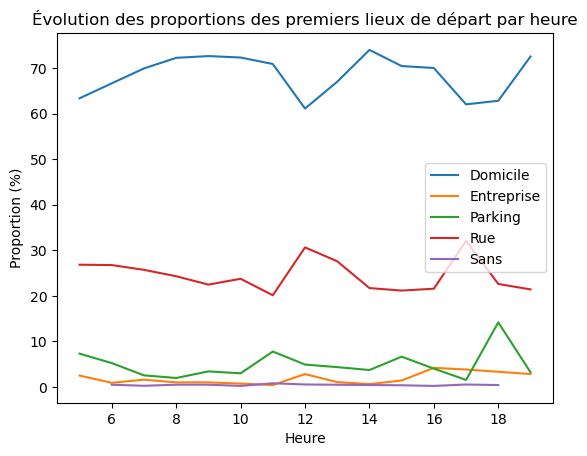

In [78]:
for h in range(0,24):
    EMP_prems.loc[(EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) >= h) & (EMP_prems["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float) <= h+1), "H_ARR"]=int(h)

count_occ_pond(EMP_prems, "H_ARR", "POND_JOUR") #heure d'arrivée du premier trajet en semaine
results=[] #tableau des occurences pondérées heure par heure pour un graphique
for h in range(0,24) :
    data = count_occ_pond(EMP_prems[EMP_prems["H_ARR"]==h], "Lieu_Depart", "POND_JOUR", 10)
    data["Heure"]=float(h)
    results.append(data)

results=pd.concat(results, ignore_index=True)
#On crée une fonction retirant les heures n'ayant pas assez d'occurences (étant donné qu'on affiche dans le graphique des proportions)
def limiter(df, nom_var, precision=1000):
    
    limiter=df[nom_var].sum()/precision #si une heure a moins de limiter occurences pond, alors on l'omet
    
    H_occ_pond=pd.DataFrame(df.groupby("Heure")[nom_var].sum())
    H_occ_pond = H_occ_pond.rename(columns={nom_var: "Occ_H"}) #on rajoute Occ_H, le nombre d'occurences pond par h
   
    results = pd.merge(df, H_occ_pond, on='Heure', how='left')
    results = results[results["Occ_H"] >= limiter]
    return results

results=limiter(results, "Occurences pondérées",100)

fig, ax = plt.subplots()
for key, group in results.groupby("Lieu_Depart"):
    ax.plot(group["Heure"], group["Proportion"], label=key)

ax.set_xlabel("Heure")
ax.set_ylabel("Proportion (%)")
ax.set_title("Évolution des proportions des premiers lieux de départ par heure")
ax.legend()
plt.show()


# Modélisation lieu d'arrivée par rapport à la plage horaire et le lieu de départ

Création de la variable plage horraire

In [43]:
EMP["HEURE_ARRIVEE"]=EMP["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float)
EMP["HEURE_DEPART"]=EMP["HEURE_DEPART"].replace(',', '.', regex=True).astype(float)
EMP.loc[EMP["HEURE_ARRIVEE"].between(0, 11),"Plage_horaire"] = "00-11h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(11, 14),"Plage_horaire"] = "11-14h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(14, 17),"Plage_horaire"] = "14-17h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(17, 24),"Plage_horaire"] = "17-00h"

On test la pertinence de l'utilisation de la plage horaire pour prédire le lieu d'arrivée en fonction du lieu de départ.

In [ ]:
alpha = 0.05
from scipy.stats import chi2_contingency

# Sélection du lieu de départ pour lequel nous voulons effectuer le test
for lieu_depart in EMP['Lieu_Depart'].unique():

    # Filtrer le DataFrame pour le lieu de départ spécifié
    subset = EMP[EMP['Lieu_Depart'] == lieu_depart]
    
    # Création d'un tableau de contingence pour le test du chi-carré
    contingency_table = pd.crosstab(subset['Lieu_Arrivee'], subset['Plage_horaire'])
    
    # Effectuer le test du chi-carré
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Afficher les résultats
    #print("Chi-square statistic:", chi2)
    #print("p-value:", p_value)
    
    # Interprétation du test
    if p_value < alpha:
        print("Il y a une relation statistiquement significative entre le lieu d'arrivée et la plage horaire pour le lieu de départ", lieu_depart)
    else:
        print("Il n'y a pas de relation statistiquement significative entre le lieu d'arrivée et la plage horaire pour le lieu de départ", lieu_depart)


Pour chaque lieu de stationnement et chaque plage horaire, on va calculer les probailités du prochain lieu de stationnement

In [ ]:
#On va créer un e fonction liée à count_occ_pound qui pour chaque plage horaire va nous envoyer la proba de Lieu_Arrivee pour chaque Lieu_Depart

def transition_plage(plage):
    Lieux = ["Domicile","Rue","Entreprise","Parking","Sans"] 
    results=None
    for Lieu in Lieux:
        data = EMP[(EMP["Plage_horaire"] == plage) & (EMP["Lieu_Depart"] == Lieu)]
        results_temp = count_occ_pond(data, 'Lieu_Arrivee', 'POND_JOUR').iloc[:, [0, 2]]

        results_temp["Proportion"] = round(results_temp["Proportion"] / 100,2)
        results_temp.rename(columns={'Proportion': 'Proba'+'_'+Lieu}, inplace=True)


        if results is None: #on fusionne toutes les proportions pour créer la matrice
            results = results_temp
        else:
            results = pd.merge(results, results_temp, on='Lieu_Arrivee')

    return results


# Appel de la fonction avec la plage "00-11h"
transition_plage("11-14h")

In [ ]:
#Maintenant on va créer une fonction à laquelle on donne un lieu de départ et une heure de départ et qui nous donne un lieu d'arrivée
#En suivant les proba obtenues ci-dessus

def lieu_arrivee(lieu_depart, heure_depart): #juste l'heure, les minutes ne sont pas utiles
    if heure_depart<11: #on trouve la plage horaire correspondante
        plage="00-11h"
    elif heure_depart<14 :
        plage="11-14h"
    elif heure_depart<17 :
        plage="14-17h"
    else:
        plage="17-00h"

    table=transition_plage(plage)[["Lieu_Arrivee", "Proba_"+lieu_depart]] #on prend les proba de déplacement pour cette plage et ce lieu de départ
    
    proba_parking = table.loc[table["Lieu_Arrivee"] == "Parking"].iloc[0,1]#proba d'aller dans un parking selon l'heure et le lieu de départ donnés.
    proba_domicile = table.loc[table["Lieu_Arrivee"] == "Domicile"].iloc[0,1]
    proba_rue = table.loc[table["Lieu_Arrivee"] == "Rue"].iloc[0,1]
    proba_entreprise = table.loc[table["Lieu_Arrivee"] == "Entreprise"].iloc[0,1]
    proba_sans = table.loc[table["Lieu_Arrivee"] == "Sans"].iloc[0,1]
    
    tirage=random.uniform(0, 1) #on construit la loi avec les probas obtenues
    if tirage < proba_parking:
        Lieu_Arrivee="Parking"
    elif tirage < proba_parking + proba_domicile:
        Lieu_Arrivee="Domicile"
    elif tirage < proba_parking + proba_domicile + proba_rue:
        Lieu_Arrivee="Rue"
    elif tirage < proba_parking + proba_domicile + proba_rue + proba_entreprise:
        Lieu_Arrivee="Entreprise"
    else:
        Lieu_Arrivee="Sans"
    
    return Lieu_Arrivee

lieu_arrivee("Domicile", 13.30)

In [ ]:
def ecart_plage(plage):
    Lieux = ["Domicile", "Rue", "Entreprise", "Parking", "Sans"] 
    results = None
    for Lieu in Lieux:
        data = EMP[(EMP["Plage_horaire"] == plage) & (EMP["Lieu_Depart"] == Lieu)]
        n_lieu = data.shape[0]
        results_temp = count_occ_pond(data, 'Lieu_Arrivee', 'POND_JOUR').iloc[:, [0, 2]]
        results_temp["Proportion"] = results_temp["Proportion"] / 100
        results_temp.rename(columns={'Proportion': 'IntConf' + '_' + Lieu}, inplace=True)
        # Calcul de l'intervalle de confiance à l'aide de la formule pour une proportion
        se = np.sqrt(results_temp['IntConf' + '_' + Lieu] * (1 - results_temp['IntConf' + '_' + Lieu]) / n_lieu**1.5)        
        z = 1.96  # Valeur critique pour un intervalle de confiance de 95%
        lower_bound = round(results_temp['IntConf' + '_' + Lieu] - z * se,3)
        upper_bound = round(results_temp['IntConf' + '_' + Lieu] + z * se,3)
        results_temp['IntConf' + '_' + Lieu] = '[' + lower_bound.astype(str) + ', ' + upper_bound.astype(str) + ']'
        if results is None:
            results = results_temp
        else:
            results = pd.merge(results, results_temp, on='Lieu_Arrivee')
    return results

# Appel de la fonction avec la plage "00-11h"
ecart_plage("00-11h")


Lieu d'arrivée en fonction du nombre de déplacemrnt ou des lieux d'arrivée précédant

In [49]:
#on teste la précision de nos prédictions

from sklearn.model_selection import train_test_split
#création d'une variable weekend (si les diffs entre samedi et dimanche sont faibles)
EMP.loc[:, "WE"] = 0
EMP.loc[EMP["TYPE_jour"].isin(["samedi", "dimanche"]), "WE"] = 1
# Diviser les données en ensembles d'entraînement et de test (80/20)
train_EMP, test_EMP = train_test_split(EMP[EMP["WE"]==0], test_size=0.2, random_state=42)

#On va créer un e fonction liée à count_occ_pound qui pour chaque plage horaire va nous envoyer la proba de Lieu_Arrivee pour chaque Lieu_Depart

def transition_plage(plage):
    Lieux = ["Domicile","Rue","Entreprise","Parking","Sans"] 
    results=None
    for Lieu in Lieux:
        data = train_EMP[(train_EMP["Plage_horaire"] == plage) & (train_EMP["Lieu_Depart"] == Lieu)]
        results_temp = count_occ_pond(data, 'Lieu_Arrivee', 'POND_JOUR').iloc[:, [0, 2]]

        results_temp["Proportion"] = round(results_temp["Proportion"] / 100,2)
        results_temp.rename(columns={'Proportion': 'Proba'+'_'+Lieu}, inplace=True)


        if results is None: #on fusionne toutes les proportions pour créer la matrice
            results = results_temp
        else:
            results = pd.merge(results, results_temp, on='Lieu_Arrivee')

    return results

#Maintenant on va créer une fonction à laquelle on donne un lieu de départ et une heure de départ et qui nous donne un lieu d'arrivée
#En suivant les proba obtenues ci-dessus

def lieu_arrivee(lieu_depart, heure_depart): #juste l'heure, les minutes ne sont pas utiles
    if heure_depart<11: #on trouve la plage horaire correspondante
        plage="00-11h"
    elif heure_depart<14 :
        plage="11-14h"
    elif heure_depart<17 :
        plage="14-17h"
    else:
        plage="17-00h"

    table=transition_plage(plage)[["Lieu_Arrivee", "Proba_"+lieu_depart]] #on prend les proba de déplacement pour cette plage et ce lieu de départ
    
    # Vérifier si des lignes correspondent à la condition "Lieu_Arrivee == 'Parking'"
    if not table[table["Lieu_Arrivee"] == "Parking"].empty:
        proba_parking = table.loc[table["Lieu_Arrivee"] == "Parking"].iloc[0, 1]
    else:
        proba_parking = 0
    
    # Vérifier si des lignes correspondent à la condition "Lieu_Arrivee == 'Domicile'"
    if not table[table["Lieu_Arrivee"] == "Domicile"].empty:
        proba_domicile = table.loc[table["Lieu_Arrivee"] == "Domicile"].iloc[0, 1]
    else:
        proba_domicile = 0
    
    # Vérifier si des lignes correspondent à la condition "Lieu_Arrivee == 'Rue'"
    if not table[table["Lieu_Arrivee"] == "Rue"].empty:
        proba_rue = table.loc[table["Lieu_Arrivee"] == "Rue"].iloc[0, 1]
    else:
        proba_rue = 0
    
    # Vérifier si des lignes correspondent à la condition "Lieu_Arrivee == 'Entreprise'"
    if not table[table["Lieu_Arrivee"] == "Entreprise"].empty:
        proba_entreprise = table.loc[table["Lieu_Arrivee"] == "Entreprise"].iloc[0, 1]
    else:
        proba_entreprise = 0
    
    # Vérifier si des lignes correspondent à la condition "Lieu_Arrivee == 'Sans'"
    if not table[table["Lieu_Arrivee"] == "Sans"].empty:
        proba_sans = table.loc[table["Lieu_Arrivee"] == "Sans"].iloc[0, 1]
    else:
        proba_sans = 0

    
    tirage=random.uniform(0, 1) #on construit la loi avec les probas obtenues
    if tirage < proba_parking:
        Lieu_Arrivee="Parking"
    elif tirage < proba_parking + proba_domicile:
        Lieu_Arrivee="Domicile"
    elif tirage < proba_parking + proba_domicile + proba_rue:
        Lieu_Arrivee="Rue"
    elif tirage < proba_parking + proba_domicile + proba_rue + proba_entreprise:
        Lieu_Arrivee="Entreprise"
    else:
        Lieu_Arrivee="Sans"
    
    return Lieu_Arrivee

# Supposons que 'test_data' contient votre ensemble de données de test, avec les colonnes 'lieu_depart' et 'heure_depart'

# Définir une liste pour stocker les prédictions
predictions = []

# Appliquer le prédicteur sur chaque ligne de l'ensemble de données de test
for index, row in test_EMP.iterrows():
    lieu_depart = row['Lieu_Depart']
    heure_depart = row['HEURE_DEPART']
    prediction = lieu_arrivee(lieu_depart, heure_depart)  # Appeler la fonction prédicteur
    predictions.append(prediction)

# Ajouter les prédictions à l'ensemble de données de test
test_EMP['prediction_lieu_arrivee'] = predictions

# Maintenant, test_data contient une colonne supplémentaire 'prediction_lieu_arrivee' avec les prédictions de votre prédicteur.


from sklearn.metrics import precision_score

# Supposons que 'vraies_labels' contient les vraies étiquettes et 'prediction_lieu_arrivee' contient les prédictions de votre modèle
vraies_labels = test_EMP['Lieu_Arrivee']
predictions = test_EMP['prediction_lieu_arrivee']

# Calculer la précision
precision = precision_score(vraies_labels, predictions, average='weighted')

# Afficher la précision
print("Précision :", precision)


Précision : 0.32465904299575205


In [41]:
EMP

,IDENT_IND,IDENT_MEN,MVEH,POND_JOUR,MOTPREC,MMOTIFDES,MSTATION,Motif,Stationnement,Lieu_Depart,...,MVEHEXT,INSTANT_DEPART,INSTANT_ARRIVEE,DISTANCE,KVAQUIV,TRAVAILLE,Segment_detail,IDENT_V,Segment,num_dep_V
0,110000011400001,1100000114000,1,"9891,108772",1.1,2.1,5,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Domicile,...,NaN,2029-01-03 14:15:00,2029-01-03 14:20:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,1
1,110000011400001,1100000114000,1,"9891,108772",2.1,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,NaN,2029-01-03 14:45:00,2029-01-03 14:50:00,"2,2",1.0,2,Particulier,110000011400001_1_Particulier,Particulier,2
2,110000011500001,1100000115000,2,"5275,2959481",1.1,1.4,6,"Étudier (école, lycée, université)",Emplacement dans un parking public ou commerci...,Domicile,...,NaN,2029-01-05 07:45:00,2029-01-05 08:45:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,1
3,110000011500001,1100000115000,2,"5275,2959481",1.4,1.1,4,Retour au domicile,"Emplacement privé, gratuit (y compris domicile)",Parking,...,NaN,2029-01-05 10:30:00,2029-01-05 11:00:00,28,1.0,2,Particulier,110000011500001_2_Particulier,Particulier,2
4,110000013500002,1100000135000,1,"24058,724023",1.1,9.1,4,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Domicile,...,NaN,2029-01-03 15:00:00,2029-01-03 15:15:00,"5,3214103219",1.0,1,Particulier,110000013500002_1_Particulier,Particulier,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22521,940000044100001,9400000441000,1,"15761,857518",3.1,2.1,5,Se rendre dans une grande surface ou un centre...,Emplacement dans un parking public ou commerci...,Rue,...,NaN,2029-01-03 10:30:00,2029-01-03 10:35:00,1,1.0,2,Particulier,940000044100001_1_Particulier,Particulier,2
22522,940000044100001,9400000441000,1,"15761,857518",2.1,4.1,3,"Démarche administrative, recherche d'informations","Stationnement sur la voie publique, payant",Parking,...,NaN,2029-01-03 11:30:00,2029-01-03 11:35:00,1,1.0,2,Particulier,940000044100001_1_Particulier,Particulier,3
22523,940000044100001,9400000441000,1,"15761,857518",4.1,1.1,1,Retour au domicile,"Stationnement sur la voie publique, gratuit sa...",Rue,...,NaN,2029-01-03 12:00:00,2029-01-03 13:00:00,"36,476190476",1.0,2,Particulier,940000044100001_1_Particulier,Particulier,4
22524,940000052100001,9400000521000,2,"14068,334434",1.1,9.1,4,Travailler dans son lieu fixe et habituel,"Emplacement privé, gratuit (y compris domicile)",Rue,...,NaN,2029-01-03 06:00:00,2029-01-03 06:45:00,"21,661727133",1.0,1,Particulier,940000052100001_2_Particulier,Particulier,1


# Vitesse

Calculer la vitesse moyenne (normalement 34), comme ça lorsqu'on simulera, on aura les distances parcourues, donc la consommation électrique (consommation = 16 kWh/100km). Et on pourra faire les courbes de charges avec des données provenant d'EDF.

In [ ]:
EMP["Temps_trajet"]=EMP["HEURE_ARRIVEE"]-EMP["HEURE_DEPART"]

In [ ]:
EMP["DISTANCE"]=EMP["DISTANCE"].replace(',', '.', regex=True).astype(float)
EMP["VITESSE"]=EMP["DISTANCE"]/EMP["Temps_trajet"]
EMP[(EMP["VITESSE"] >= 0.1) & (EMP["VITESSE"] <= 300)]["VITESSE"].describe()
#on retire les vitesses erronées, cela change peu la moyenne

In [ ]:
plt.hist(EMP["VITESSE"], bins=30, range=(0, 150))  # Utilisation de 30 bins et de la plage (0, 150)
plt.xlabel('Vitesse')
plt.ylabel('Fréquence')
plt.title('Histogramme de la vitesse')
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


def coefvitesse(data): #on prend le sample EMP qui nous intéresse

    # Transformez la variable PLAGE_HORAIRE en indicatrice
    data = pd.get_dummies(data, columns=['Plage_horaire'])
    data['Plage_horaire_00-11h']=data['Plage_horaire_00-11h'].astype('int')
    data['Plage_horaire_11-14h']=data['Plage_horaire_11-14h'].astype('int')
    data['Plage_horaire_14-17h']=data['Plage_horaire_14-17h'].astype('int')
    
    data["Temps_trajet"]=data["HEURE_ARRIVEE"]-data["HEURE_DEPART"]
    data["DISTANCE"]=data["DISTANCE"].replace(',', '.', regex=True).astype(float)
    data["VITESSE"]=data["DISTANCE"]/data["Temps_trajet"]
    data=data[["Temps_trajet", 'Plage_horaire_00-11h', 'Plage_horaire_11-14h', 'Plage_horaire_14-17h',"VITESSE"]].dropna()
    # Diviser les données en ensembles d'entraînement (80%) et de test (20%)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    
    # Séparez les variables explicatives (X) et la variable cible (y)
    X = train_data[["Temps_trajet", 'Plage_horaire_00-11h', 'Plage_horaire_11-14h', 'Plage_horaire_14-17h']]
    y = train_data['VITESSE']
    
# Créez le modèle de régression linéaire
    model = sm.OLS(y, sm.add_constant(X))
    
    # Ajustez le modèle aux données
    results = model.fit()

    # Préparation des données de prédiction
    pred_X = test_data[["Temps_trajet", 'Plage_horaire_00-11h', 'Plage_horaire_11-14h', 'Plage_horaire_14-17h']]
    pred_X = sm.add_constant(pred_X)
    
    # Prédiction sur les nouvelles données
    pred_y = results.predict(pred_X)
    
    # Ajout des valeurs prédites au DataFrame de prédiction
    test_data['Vitesse_predite'] = pred_y
    
    # Calculer l'erreur quadratique moyenne (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data['VITESSE'], test_data['Vitesse_predite']))
    
    print("Erreur quadratique moyenne (RMSE) :", rmse)

coefvitesse(EMP)



On va faire une fonction qui en fonction de la plage horaire et du temps de trajet assigne une vitesse

In [ ]:
def coefvitesse2(data): #on prend le sample EMP qui nous intéresse
    
    data["Temps_trajet"]=data["HEURE_ARRIVEE"]-data["HEURE_DEPART"]
    data["DISTANCE"]=data["DISTANCE"].replace(',', '.', regex=True).astype(float)
    data["VITESSE"]=data["DISTANCE"]/data["Temps_trajet"]
    data=data[["Temps_trajet", 'HEURE_DEPART',"VITESSE"]].dropna()
    # Diviser les données en ensembles d'entraînement (80%) et de test (20%)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    
    # Séparez les variables explicatives (X) et la variable cible (y)
    X = train_data[["Temps_trajet", 'HEURE_DEPART']]
    y = train_data['VITESSE']
    
# Créez le modèle de régression linéaire
    model = sm.OLS(y, sm.add_constant(X))
    
    # Ajustez le modèle aux données
    results = model.fit()

    # Préparation des données de prédiction
    pred_X = test_data[["Temps_trajet", 'HEURE_DEPART']]
    pred_X = sm.add_constant(pred_X)
    
    # Prédiction sur les nouvelles données
    pred_y = results.predict(pred_X)
    
    # Ajout des valeurs prédites au DataFrame de prédiction
    test_data['Vitesse_predite'] = pred_y
    
    # Calculer l'erreur quadratique moyenne (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data['VITESSE'], test_data['Vitesse_predite']))
    
    print("Erreur quadratique moyenne (RMSE) :", rmse)

coefvitesse2(EMP)

# Nombre de lieux visités

In [ ]:
mean_max_num_dep_V = EMP.groupby("IDENT_IND")["num_dep_V"].max().reset_index()["num_dep_V"].mean()
std_max_num_dep_V = EMP.groupby("IDENT_IND")["num_dep_V"].max().reset_index()["num_dep_V"].std()
std_max_num_dep_V, mean_max_num_dep_V

In [ ]:

from scipy.stats import ttest_ind

def adequation_moyenne_nombre_voyages(EMP, simu):
    # Calculer la moyenne des valeurs maximum de "num_dep_V" pour EMP1 et EMP2
    mean_max_num_dep_V_EMP1 = EMP.groupby("IDENT_IND")["num_dep_V"].max().reset_index()["num_dep_V"].mean()
    mean_max_num_dep_V_EMP2 = simu.groupby("IDENT_IND")["num_dep_V"].max().reset_index()["num_dep_V"].mean()
    
    print(f"Moyenne de nombre de trajets par journée pour EMP : {mean_max_num_dep_V_EMP1}")
    print(f"Moyenne de nombre de trajets par journée pour les simulations : {mean_max_num_dep_V_EMP2}")
    
    # Effectuer un test d'adéquation (test t de Student indépendant)
    t_stat, p_value = ttest_ind(EMP.groupby("IDENT_IND")["num_dep_V"].max(), 
                                simu.groupby("IDENT_IND")["num_dep_V"].max())
    
    print(f"Statistique de test t : {t_stat}")
    print(f"Valeur p : {p_value}")
    
    # Interpréter le résultat du test
    alpha = 0.05
    if p_value < alpha:
        print("On rejette à 5% l'hypothèse d'adéquation")
    else:
        print("On ne peut pas rejeter à 5% l'hypothèse d'adéquation")

adequation_moyenne_nombre_voyages(EMP,EMP)

In [ ]:
from scipy.stats import ttest_ind_from_stats
import numpy as np

def compare_weighted_means_and_test_adequacy(EMP1, simu):
    # Calculer la moyenne et l'écart-type des valeurs maximum de "num_dep_V" pour EMP1 et EMP2
    mean1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().mean()
    std1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().std()
    nobs1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().count()

    mean2 = simu.groupby("IDENT_IND")["num_dep_V"].max().mean()
    std2 = simu.groupby("IDENT_IND")["num_dep_V"].max().std()
    nobs2 = simu.groupby("IDENT_IND")["num_dep_V"].max().count()

    print(f"Moyenne de num_dep_V pour EMP1 : {mean1}")
    print(f"Moyenne de num_dep_V pour EMP2 : {mean2}")

    # Effectuer un test d'adéquation pondéré (test t de Student indépendant à partir des statistiques)
    t_stat, p_value = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                                           mean2=mean2, std2=std2, nobs2=nobs2)

    print(f"Statistique de test t : {t_stat}")
    print(f"Valeur p : {p_value}")

    # Interpréter le résultat du test
    alpha = 0.05
    if p_value < alpha:
        print("Les moyennes sont statistiquement différentes.")
    else:
        print("Les moyennes sont statistiquement similaires.")


In [ ]:

# Trier le DataFrame par 'IDENT_IND' et 'heure_depart'
EMP = EMP.sort_values(by=['IDENT_IND', 'HEURE_DEPART'])

# Calculer le temps d'attente pour chaque trajet
EMP['temps_attente'] = EMP.groupby('IDENT_IND')['HEURE_DEPART'].diff().fillna(EMP["HEURE_DEPART"])

# Identifier le dernier trajet de la journée pour chaque individu
EMP['dernier_trajet_journee'] = EMP.groupby('IDENT_IND')['HEURE_ARRIVEE'].transform('max')

# Calculer le temps d'attente jusqu'à minuit pour le dernier trajet de chaque journée
EMP['temps_attente_jusqua_minuit'] = 24 - EMP['dernier_trajet_journee']


# Mettre à 0 le temps d'attente jusqu'à minuit lorsque heure_arrivee est différent de dernier_trajet_journee
EMP.loc[EMP['HEURE_ARRIVEE'] != EMP['dernier_trajet_journee'], 'temps_attente_jusqua_minuit'] = 0


# Afficher le DataFrame avec les temps d'attente
print(EMP[['IDENT_IND', 'temps_attente','Lieu_Depart','Lieu_Arrivee', 'temps_attente_jusqua_minuit']])

In [ ]:
# Regrouper les données par 'IDENT_IND' et 'Lieu_Depart' et sommer les temps d'attente
EMP_ATT = EMP.groupby(['IDENT_IND', 'Lieu_Depart', 'Lieu_Arrivee'])[['temps_attente', 'temps_attente_jusqua_minuit']].sum().reset_index()

# Sélectionner les colonnes nécessaires pour EMP_ATT1 et renommer les colonnes
EMP_ATT1 = EMP_ATT[["IDENT_IND", "Lieu_Depart", "temps_attente"]].copy()
EMP_ATT1.rename(columns={
    'IDENT_IND': 'Identifiant',
    'Lieu_Depart': 'Lieu',
    'temps_attente': 'TempsAttente'
}, inplace=True)

# Sélectionner les colonnes nécessaires pour EMP_ATT2, ajuster la colonne temps_attente_jusqua_minuit et renommer la colonne
EMP_ATT2 = EMP_ATT[["IDENT_IND", "Lieu_Arrivee", "temps_attente_jusqua_minuit"]].copy()
EMP_ATT2.rename(columns={
    'IDENT_IND': 'Identifiant',
    'Lieu_Arrivee': 'Lieu',
    'temps_attente_jusqua_minuit': 'TempsAttente'
}, inplace=True)

# Concaténer les DataFrames EMP_ATT1 et EMP_ATT2, puis regrouper par 'Identifiant' et 'Lieu' et sommer les temps d'attente
EMP_ATT = pd.concat([EMP_ATT1, EMP_ATT2], ignore_index=True).groupby(['Identifiant', 'Lieu'])["TempsAttente"].sum().reset_index()
EMP_ATT['TempsAttente'] = EMP_ATT['TempsAttente'].map(lambda x: round(x, 1))
# Afficher le DataFrame final
print(EMP_ATT)


In [ ]:
# Créer une table pivot avec les lieux comme colonnes et les individus comme index
#Comme ça on a 0 lorsque l'individu n'attend pas dans ce lieu
EMP_ATT_p=EMP_ATT.pivot_table(index='Identifiant', columns='Lieu', values='TempsAttente', fill_value=0).reset_index()

# Calculer la moyenne et l'écart-type pour chaque lieu
stats_by_lieu = EMP_ATT_p.mean().reset_index().rename(columns={0: 'Moyenne'})
stats_by_lieu['EcartType'] = EMP_ATT_p.std().reset_index()[0]

# Afficher les statistiques par lieu
print(stats_by_lieu)

In [ ]:
#On crée une fonction qui va nous calculer le temps moyen passé dans chaque lieu de stationement de notre base de données
#Le but étant de comparer EMP et nos simulations
def parking(data):
    # Trier le DataFrame par 'IDENT_IND' et 'heure_depart'
    data = data.sort_values(by=['IDENT_IND', 'HEURE_DEPART'])
    
    # Calculer le temps d'attente pour chaque trajet
    data['temps_attente'] = data.groupby('IDENT_IND')['HEURE_DEPART'].diff().fillna(data["HEURE_DEPART"])
    
    # Identifier le dernier trajet de la journée pour chaque individu
    data['dernier_trajet_journee'] = data.groupby('IDENT_IND')['HEURE_ARRIVEE'].transform('max')
    
    # Calculer le temps d'attente jusqu'à minuit pour le dernier trajet de chaque journée
    data['temps_attente_jusqua_minuit'] = 24 - data['dernier_trajet_journee']
    
    # Mettre à 0 le temps d'attente jusqu'à minuit lorsque heure_arrivee est différent de dernier_trajet_journee
    data.loc[EMP['HEURE_ARRIVEE'] != data['dernier_trajet_journee'], 'temps_attente_jusqua_minuit'] = 0

    # Regrouper les données par 'IDENT_IND' et 'Lieu_Depart' et sommer les temps d'attente
    EMP_ATT = data.groupby(['IDENT_IND', 'Lieu_Depart', 'Lieu_Arrivee'])[['temps_attente', 'temps_attente_jusqua_minuit']].sum().reset_index()
    
    # Sélectionner les colonnes nécessaires pour EMP_ATT1 et renommer les colonnes
    EMP_ATT1 = EMP_ATT[["IDENT_IND", "Lieu_Depart", "temps_attente"]].copy()
    EMP_ATT1.rename(columns={
        'IDENT_IND': 'Identifiant',
        'Lieu_Depart': 'Lieu',
        'temps_attente': 'TempsAttente'
    }, inplace=True)
    
    # Sélectionner les colonnes nécessaires pour EMP_ATT2, ajuster la colonne temps_attente_jusqua_minuit et renommer la colonne
    EMP_ATT2 = EMP_ATT[["IDENT_IND", "Lieu_Arrivee", "temps_attente_jusqua_minuit"]].copy()
    EMP_ATT2.rename(columns={
        'IDENT_IND': 'Identifiant',
        'Lieu_Arrivee': 'Lieu',
        'temps_attente_jusqua_minuit': 'TempsAttente'
    }, inplace=True)
    
    # Concaténer les DataFrames EMP_ATT1 et EMP_ATT2, puis regrouper par 'Identifiant' et 'Lieu' et sommer les temps d'attente
    EMP_ATT = pd.concat([EMP_ATT1, EMP_ATT2], ignore_index=True).groupby(['Identifiant', 'Lieu'])["TempsAttente"].sum().reset_index() 

    # Créer une table pivot avec les lieux comme colonnes et les individus comme index
    #Comme ça on a 0 lorsque l'individu n'attend pas dans ce lieu
    EMP_ATT_p=EMP_ATT.pivot_table(index='Identifiant', columns='Lieu', values='TempsAttente', fill_value=0).reset_index()

    return EMP_ATT_p
parking(EMP)

In [ ]:
#on retire sans car il est colinéaire aux autres et ruine la représentation graphique
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les colonnes des cinq lieux
lieux = ['Domicile', 'Rue', 'Entreprise', 'Parking']

# Créer un sous-ensemble du DataFrame pivot_table avec seulement les colonnes des cinq lieux
sub_df = parking(EMP)[lieux]

# Redimensionner les données pour les avoir sous forme de colonne pour seaborn
melted_df = sub_df.melt(var_name='Lieu', value_name='TempsAttente')

# Tracer le graphique de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(data=melted_df, x='TempsAttente', hue='Lieu', fill=True, common_norm=False)
plt.title('Densité des lieux de stationement')
plt.xlabel('Temps de stationement')
plt.ylabel('Densité')
plt.show()


In [ ]:
EMP_ATT_p=parking(EMP) 
# Calculer la moyenne et l'écart-type pour chaque lieu
stats_by_lieu = EMP_ATT_p.mean().reset_index().rename(columns={0: 'Moyenne'})
stats_by_lieu['EcartType'] = EMP_ATT_p.std().reset_index()[0]

print(stats_by_lieu)
    

In [ ]:
from scipy.stats import ks_2samp

def kolmosmir(test_data, simulation):

    pivot_table1 = parking(test_data)
    pivot_table2 = parking(simulation)
    # Sélectionner les colonnes des cinq lieux
    lieux = ['Domicile', 'Rue', 'Entreprise', 'Sans', 'Parking']
    
    # Créer des DataFrames pour stocker les résultats des tests
    ks_results = pd.DataFrame(index=lieux, columns=['statistic', 'pvalue', 'nobs1', 'nobs2', 'accepte_hypothese'])

    alpha=0.05
    
    # Effectuer le test de Kolmogorov-Smirnov pour chaque lieu
    for lieu in lieux:
        # Calculer les statistiques pour les deux distributions
        ks_statistic, ks_pvalue = ks_2samp(pivot_table1[lieu], pivot_table2[lieu])
        nobs_test = len(pivot_table1[lieu])
        nobs_simu = len(pivot_table2[lieu])
            # Déterminer si l'hypothèse est acceptée ou rejetée
        accepte_hypothese = ks_pvalue > alpha
        
        # Stocker les résultats dans le DataFrame
        ks_results.loc[lieu] = [ks_statistic, ks_pvalue, nobs_test, nobs_simu, accepte_hypothese]
    
    # Afficher les résultats des tests
    return ks_results

kolmosmir(EMP, EMP)

In [ ]:
from scipy.stats import ttest_ind_from_stats

def compare_weighted_means_and_test_adequacy(EMP1, simu):
    # Calculer la moyenne et l'écart-type des valeurs maximum de "num_dep_V" pour EMP1 et EMP2
    mean1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().mean()
    std1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().std()
    nobs1 = EMP1.groupby("IDENT_IND")["num_dep_V"].max().count()

    mean2 = simu.groupby("IDENT_IND")["num_dep_V"].max().mean()
    std2 = simu.groupby("IDENT_IND")["num_dep_V"].max().std()
    nobs2 = simu.groupby("IDENT_IND")["num_dep_V"].max().count()

    print(f"Moyenne de num_dep_V pour EMP1 : {mean1}")
    print(f"Moyenne de num_dep_V pour EMP2 : {mean2}")

    # Effectuer un test d'adéquation pondéré (test t de Student indépendant à partir des statistiques)
    t_stat, p_value = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                                           mean2=mean2, std2=std2, nobs2=nobs2)

    print(f"Statistique de test t : {t_stat}")
    print(f"Valeur p : {p_value}")

    # Interpréter le résultat du test
    alpha = 0.05
    if p_value < alpha:
        print("Les moyennes sont statistiquement différentes.")
    else:
        print("Les moyennes sont statistiquement similaires.")


#On crée une fonction qui va nous calculer le temps moyen passé dans chaque lieu de stationement de notre base de données
#Le but étant de comparer EMP et nos simulations
def parking(data):
    # Trier le DataFrame par 'IDENT_IND' et 'heure_depart'
    data = data.sort_values(by=['IDENT_IND', 'HEURE_DEPART'])
    
    # Calculer le temps d'attente pour chaque trajet
    data['temps_attente'] = data.groupby('IDENT_IND')['HEURE_DEPART'].diff().fillna(data["HEURE_DEPART"])
    
    # Identifier le dernier trajet de la journée pour chaque individu
    data['dernier_trajet_journee'] = data.groupby('IDENT_IND')['HEURE_ARRIVEE'].transform('max')
    
    # Calculer le temps d'attente jusqu'à minuit pour le dernier trajet de chaque journée
    data['temps_attente_jusqua_minuit'] = 24 - data['dernier_trajet_journee']
    
    # Mettre à 0 le temps d'attente jusqu'à minuit lorsque heure_arrivee est différent de dernier_trajet_journee
    data.loc[EMP['HEURE_ARRIVEE'] != data['dernier_trajet_journee'], 'temps_attente_jusqua_minuit'] = 0

    # Regrouper les données par 'IDENT_IND' et 'Lieu_Depart' et sommer les temps d'attente
    EMP_ATT = data.groupby(['IDENT_IND', 'Lieu_Depart', 'Lieu_Arrivee'])[['temps_attente', 'temps_attente_jusqua_minuit']].sum().reset_index()
    
    # Sélectionner les colonnes nécessaires pour EMP_ATT1 et renommer les colonnes
    EMP_ATT1 = EMP_ATT[["IDENT_IND", "Lieu_Depart", "temps_attente"]].copy()
    EMP_ATT1.rename(columns={
        'IDENT_IND': 'Identifiant',
        'Lieu_Depart': 'Lieu',
        'temps_attente': 'TempsAttente'
    }, inplace=True)
    
    # Sélectionner les colonnes nécessaires pour EMP_ATT2, ajuster la colonne temps_attente_jusqua_minuit et renommer la colonne
    EMP_ATT2 = EMP_ATT[["IDENT_IND", "Lieu_Arrivee", "temps_attente_jusqua_minuit"]].copy()
    EMP_ATT2.rename(columns={
        'IDENT_IND': 'Identifiant',
        'Lieu_Arrivee': 'Lieu',
        'temps_attente_jusqua_minuit': 'TempsAttente'
    }, inplace=True)
    
    # Concaténer les DataFrames EMP_ATT1 et EMP_ATT2, puis regrouper par 'Identifiant' et 'Lieu' et sommer les temps d'attente
    EMP_ATT = pd.concat([EMP_ATT1, EMP_ATT2], ignore_index=True).groupby(['Identifiant', 'Lieu'])["TempsAttente"].sum().reset_index() 

    # Créer une table pivot avec les lieux comme colonnes et les individus comme index
    #Comme ça on a 0 lorsque l'individu n'attend pas dans ce lieu
    EMP_ATT_p=EMP_ATT.pivot_table(index='Identifiant', columns='Lieu', values='TempsAttente', fill_value=0).reset_index()

    return EMP_ATT_p

from scipy.stats import ks_2samp

def kolmosmir(test_data, simulation):

    pivot_table1 = parking(test_data)
    pivot_table2 = parking(simulation)
    # Sélectionner les colonnes des cinq lieux
    lieux = ['Domicile', 'Rue', 'Entreprise', 'Sans', 'Parking']
    
    # Créer des DataFrames pour stocker les résultats des tests
    ks_results = pd.DataFrame(index=lieux, columns=['statistic', 'pvalue', 'nobs1', 'nobs2', 'accepte_hypothese'])

    alpha=0.05
    
    # Effectuer le test de Kolmogorov-Smirnov pour chaque lieu
    for lieu in lieux:
        # Calculer les statistiques pour les deux distributions
        ks_statistic, ks_pvalue = ks_2samp(pivot_table1[lieu], pivot_table2[lieu])
        nobs_test = len(pivot_table1[lieu])
        nobs_simu = len(pivot_table2[lieu])
            # Déterminer si l'hypothèse est acceptée ou rejetée
        accepte_hypothese = ks_pvalue > alpha
        
        # Stocker les résultats dans le DataFrame
        ks_results.loc[lieu] = [ks_statistic, ks_pvalue, nobs_test, nobs_simu, accepte_hypothese]
    
    # Afficher les résultats des tests
    return ks_results




In [57]:


# Définir les intervalles pour regrouper les heures de départ
intervalles = pd.interval_range(start=0, end=24, freq=3)

# Créer une nouvelle colonne contenant les intervalles des heures de départ
EMP['heure_depart_interval'] = pd.cut(EMP['HEURE_DEPART'], bins=intervalles)

# Afficher le tableau du nombre de lignes par intervalle d'heure de départ
nombre_lignes_par_interval = EMP['heure_depart_interval'].value_counts()
print("Tableau du nombre de lignes par INTERVALLE_HEURE_DEPART :")
print(nombre_lignes_par_interval)


Tableau du nombre de lignes par INTERVALLE_HEURE_DEPART :
heure_depart_interval
(15, 18]    5472
(9, 12]     5329
(12, 15]    4225
(6, 9]      3697
(18, 21]    2851
(21, 24]     590
(3, 6]       350
(0, 3]        12
Name: count, dtype: int64


In [56]:
# Supposons que votre DataFrame s'appelle 'emp_data'
nombre_de_lignes = EMP.shape[0]

# Afficher le nombre de lignes
print("Nombre de lignes dans le dataset :", nombre_de_lignes)


Nombre de lignes dans le dataset : 22526
